In [1]:
'''
필요한 라이브러리 불러오기
'''

import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

from torchvision import datasets, transforms

device = torch.device("cuda")  # 학습에 사용할 장치 (GPU 또는 CPU)

In [2]:
'''
MNIST 데이터셋 불러오기
'''

dataset = datasets.MNIST(
    root="data",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

batch_size = 1024  # 한 번에 학습할 데이터 개수

dataloaders = torch.utils.data.DataLoader(
    dataset,
    batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

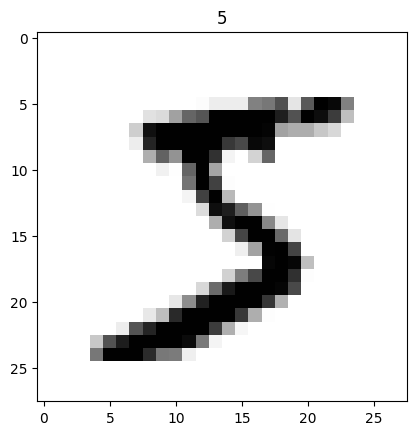

In [3]:
'''
MNIST 데이터셋 시각화
'''

import matplotlib.pyplot as plt


def plot_mnist(img, lbl):
    plt.imshow(img[0], cmap="binary")
    plt.title(lbl)
    plt.show()


image, label = dataset[0]
plot_mnist(image, label)

In [4]:
'''
AutoEncoder 모델 구현
'''

space_size = 10  # Latent space 차원


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, space_size),
            nn.ReLU()
        )

    def forward(self, x):
        return self.mlp(x)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(space_size, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.mlp(x)


class AutoEncoder(nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.encoder = enc
        self.decoder = dec

        # He initialization
        for name, param in self.named_parameters():
            if "weight" in name:
                nn.init.kaiming_uniform_(param, nonlinearity="relu")
            elif "bias" in name:
                nn.init.zeros_(param)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
'''
AutoEncoder 모델 생성
'''

encoder = Encoder()
decoder = Decoder()
autoencoder = AutoEncoder(encoder, decoder).to(device)

In [6]:
'''
AutoEncoder 모델 학습
'''

epochs = 30
learning_rate = 1e-3
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

from tqdm.notebook import tqdm

for epoch in (pbar := tqdm(range(epochs))):
    for data, _ in dataloaders:
        data = data.view(-1, 28 * 28).to(device)  # 이미지를 1차원 벡터로 변환

        optimizer.zero_grad()  # 이전 학습 단계에서 계산된 기울기 지우기

        output = autoencoder(data)  # AutoEncoder 모델의 출력 계산

        loss = F.mse_loss(output, data)  # 출력과 입력의 차이를 계산하여 오차 계산
        loss.backward()  # 연쇄법칙을 사용하여 오차를 각 파라미터로 전파

        optimizer.step()  # 파라미터 업데이트 (경사하강법)

        pbar.set_postfix(loss=loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]

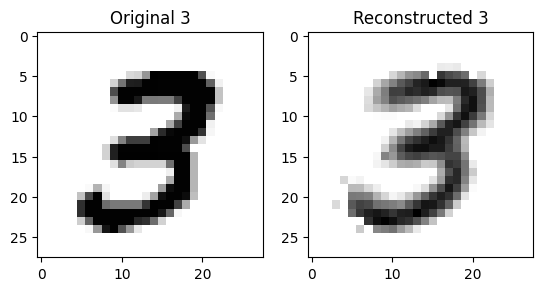

In [7]:
'''
학습된 AutoEncoder 모델 결과 확인
'''


def plot_reconstructed(img, lbl, pred):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img[0], cmap="binary")
    ax1.set_title(f"Original {lbl}")
    ax2.imshow(pred[0].detach().cpu().numpy().reshape(28, 28), cmap="binary")
    ax2.set_title(f"Reconstructed {lbl}")
    plt.show()


image, label = dataset[7]
output = autoencoder(image.view(-1, 28 * 28).to(device))
plot_reconstructed(image, label, output)

In [8]:
'''
Text to Image 모델 구현
'''

embedding_size = 10  # 단어 임베딩 차원


class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embedding_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, space_size),
            nn.ReLU()
        )

        # He initialization
        for name, param in self.named_parameters():
            if "weight" in name:
                nn.init.kaiming_uniform_(param, nonlinearity="relu")
            elif "bias" in name:
                nn.init.zeros_(param)

    def forward(self, x):
        return self.mlp(x)


class TextToImage(nn.Module):
    def __init__(self, text_enc, dec):
        super().__init__()
        self.text_encoder = text_enc
        self.decoder = dec

        # AutoEncoder의 Decoder는 학습되지 않도록 함
        self.decoder.eval()
        for param in self.decoder.parameters():
            param.requires_grad = False

    def forward(self, x):
        encoded = self.text_encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
'''
텍스트(숫자)를 원-핫 벡터로 변환
'''


def number_to_one_hot(number):
    one_hot_vec = torch.zeros(embedding_size)
    one_hot_vec[int(number)] = 1
    return one_hot_vec.to(device)

In [10]:
'''
Text to Image 모델 생성
'''

text_encoder = TextEncoder()
model = TextToImage(
    text_encoder,
    decoder,  # AutoEncoder의 Decoder를 사용!
).to(device)

In [11]:
'''
Text to Image 모델 학습
'''

epochs = 10
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in (pbar := tqdm(range(epochs))):
    for data, label in dataloaders:
        data = data.view(-1, 28 * 28).to(device)
        one_hot = torch.stack([number_to_one_hot(number) for number in label]).to(device)

        optimizer.zero_grad()

        output = model.text_encoder(one_hot)
        target = autoencoder.encoder(data)
        
        loss = F.mse_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        pbar.set_postfix(loss=loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

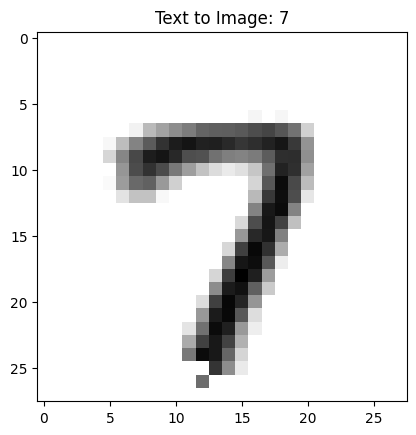

In [12]:
'''
학습된 Text to Image 모델 결과 확인
'''


def text_to_image(text):
    one_hot = number_to_one_hot(int(text))

    result = model(one_hot)
    result = result.detach().cpu().numpy().reshape(28, 28)

    plt.imshow(result, cmap="binary")
    plt.title(f"Text to Image: {text}")
    plt.show()


number = input("그릴 숫자 입력: ")
text_to_image(number)